## Download dataset

In [ ]:
!wget http://files.ipd.uw.edu/pub/MLdecoys/phipsi.pkl

In [1]:
import pickle
import numpy as np

with open('phipsi.pkl', 'rb') as f:
    dataset = pickle.load(f)

print("number of proteins: ", len(dataset))
print("keys: ", dataset[0].keys())

dataset[0]['phi'].shape

number of proteins:  10860
keys:  dict_keys(['sequence', 'phi', 'psi', 'mrf_1b', 'mrf_2b', 'neff'])


(210,)

### Skip terminal residues

In [2]:
for item in dataset:
        n = len(item['sequence'])
        item['sequence'] = item['sequence'][1:n-1]
        item['phi'] = item['phi'][1:n-1].astype(dtype=np.float32)
        item['psi'] = item['psi'][1:n-1].astype(dtype=np.float32)
        item['mrf_1b'] = item['mrf_1b'][1:n-1,:].astype(dtype=np.float32)
        item['mrf_2b'] = item['mrf_2b'][1:n-1,:].astype(dtype=np.float32)

        # convert (phi,psi) to their sin() and cos()
        # (4 numbers per angle pair)
        item['avec'] = np.vstack([
            np.sin(item['phi']).T,
            np.cos(item['phi']).T,
            np.sin(item['psi']).T,
            np.cos(item['psi']).T ]).T

In [3]:
dataset[0]['mrf_1b'].shape

(208, 21)

## Visualize some profiles

In [4]:
import matplotlib
import matplotlib.pyplot as plt

Neff=  768.225


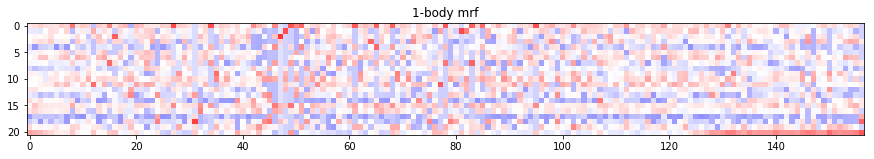

In [5]:
i = 5
a = dataset[i]['mrf_1b'].T.astype(float)
b = dataset[i]['mrf_2b'].T.astype(float)
a = a/np.std(a)
b = b/np.std(b)

print('Neff= ', dataset[i]['neff'])

fig = plt.figure(figsize=(15, 5))
matplotlib.rcParams['image.cmap'] = 'bwr'
ax = fig.add_subplot(111)
ax.set_title('1-body mrf')
plt.imshow(a, vmin=-5, vmax=5)
plt.show()

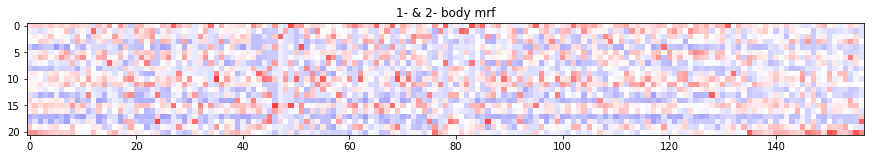

In [6]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.set_title('1- & 2- body mrf')
plt.imshow(b, vmin=-5, vmax=5)
plt.show()

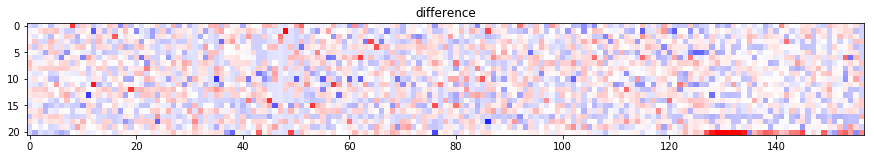

In [7]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.set_title('difference')
plt.imshow((a-b)/np.std(a-b), vmin=-5, vmax=5)
plt.show()

## Test tensorflow on GPU

In [8]:
import tensorflow as tf

print("Built with GPU:", tf.test.is_built_with_cuda())
print("GPU available:", tf.test.is_gpu_available())
print("GPU device:", tf.test.gpu_device_name())


Built with GPU: True
GPU available: True
GPU device: /device:GPU:0


## Get ready for training

### Train/test split

In [9]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(dataset, test_size=0.1, random_state=42)


### Clustering

In [10]:
from sklearn.cluster import KMeans

In [11]:
NCLUST = 20

KM = KMeans(n_clusters=NCLUST, max_iter=5, random_state=42)
KM.fit(np.vstack([item['avec'] for item in train]))


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=5,
    n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [12]:
cent = KM.cluster_centers_
cphi = np.arctan2(cent[:,0], cent[:,1])*180/np.pi
cpsi = np.arctan2(cent[:,2], cent[:,3])*180/np.pi

X_pred = KM.predict(np.vstack([item['avec'] for item in test]))

# stack phi and psi from all test proteins together
phi = np.hstack([item['phi'] for item in test])*180/np.pi
psi = np.hstack([item['psi'] for item in test])*180/np.pi


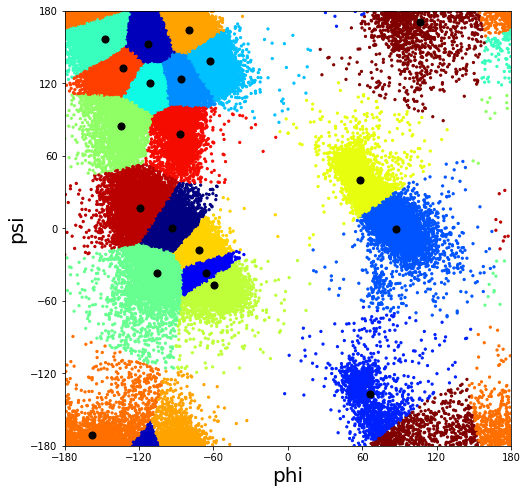

In [19]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['image.cmap'] = 'jet'

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
plt.xlim([-180, 180])
plt.ylim([-180, 180])
plt.xticks((-180,-120,-60,0,60,120,180))
plt.yticks((-180,-120,-60,0,60,120,180))
plt.xlabel('phi', fontsize=20)
plt.ylabel('psi', fontsize=20)
plt.scatter(phi, psi, c=X_pred, s=5)
plt.scatter(cphi, cpsi, c='black', s=50)
plt.show()

### Convert X,Y to 1-hot

In [14]:
# convert sequences & dihedral clusters
# to one-hot representation
for item in train:
    item['X'] = np.eye(20)[item['sequence']]
    a = item['mrf_1b']
    b = item['mrf_2b']
    #n = np.full((item['sequence'].shape[0], 1), np.log(item['neff']))
    item['X'] = np.hstack([item['X'], a, b])
    #item['X'] = np.hstack([item['X'], a])
    item['X'] = item['X'][np.newaxis]

    item['Y'] = np.eye(NCLUST)[np.array(KM.predict(item['avec']), dtype=np.int8)]
    item['Y'] = item['Y'][np.newaxis]

for item in test:
    item['X'] = np.eye(20)[item['sequence']]
    a = item['mrf_1b']
    b = item['mrf_2b']
    #n = np.full((item['sequence'].shape[0], 1), np.log(item['neff']))
    item['X'] = np.hstack([item['X'], a, b])
    #item['X'] = np.hstack([item['X'], a])
    item['X'] = item['X'][np.newaxis]

    item['Y'] = np.eye(NCLUST)[np.array(KM.predict(item['avec']), dtype=np.int8)]
    item['Y'] = item['Y'][np.newaxis]


In [15]:
p5 = train[5]
p5['X'].shape


(1, 74, 62)

## Train

In [15]:
import utils
from random import shuffle

lr           = 0.0001  # learning rate
l2_coef      = 0.001  # L2 penalty weight
nb_epochs    = 500
n_layers     = 15
n_filters    = 60
kernel_size  = 5


In [18]:
relu = tf.nn.elu
conv1d = tf.layers.conv1d

with tf.Graph().as_default():
    with tf.name_scope('input'):
        features = tf.placeholder(dtype=tf.int8, shape=(1, None, 62))
        labels = tf.placeholder(dtype=tf.int8, shape=(1, None, NCLUST))
        is_train = tf.placeholder(tf.bool, name='is_train')

    layers = []
    
    # batch normalization
    layers.append(tf.layers.batch_normalization(tf.to_float(features), training=is_train))
    
    # first convolution-activation pair
    layers.append(relu(conv1d(layers[-1], n_filters, kernel_size, padding='SAME')))

    # stack of residual layers
    for _ in range(n_layers):
        layers.append(relu(conv1d(layers[-1], n_filters, kernel_size, padding='SAME')))
        layers.append(relu(conv1d(layers[-1], n_filters, kernel_size, padding='SAME') + layers[-2]))

    # last layer - reshape to the number of clusters
    layers.append(relu(conv1d(layers[-1], NCLUST, kernel_size, padding='SAME')))

    # loss
    out = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.to_float(labels), logits=layers[-1])
    loss = tf.reduce_mean(out)

    # predicted probabilities for different
    # dihedral clusters
    prob = tf.nn.softmax(layers[-1])
    
    
    vars = tf.trainable_variables()
    lossL2 = tf.add_n([tf.nn.l2_loss(v) for v in vars if v.name not
                       in ['bias', 'gamma', 'b', 'g', 'beta']]) * l2_coef
    # optimizer
    opt = tf.train.AdamOptimizer(learning_rate=lr)

    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # training op
    train_op = opt.minimize(loss+lossL2)

    init_op = tf.group(tf.global_variables_initializer(), 
                       tf.local_variables_initializer())

    total_parameters=np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
    print("tot. params: " + str(total_parameters))
    print("tot. layers: " + str(len(layers)))
    
    with tf.Session() as sess:
        sess.run(init_op)
        
        for epoch in range(nb_epochs):
            
            train_loss = 0
            step = 0
            rmse_phi = 0
            rmse_psi = 0
            shuffle(train)
            for item in train:
                _, loss_value, _ = sess.run([train_op, loss, extra_update_ops],
                                         feed_dict={
                                             features: item['X'],
                                             labels: item['Y'],
                                             is_train: 1 })
                step += 1
                train_loss += loss_value
            train_loss /= step

            val_loss = 0
            step = 0
            s = 0
            for item in test:
                loss_value, pred, _  = sess.run([loss, prob, extra_update_ops],
                                      feed_dict={
                                          features: item['X'],
                                          labels: item['Y'],
                                          is_train: 0 })
                step += 1
                val_loss += loss_value

                # RMSE
                avec = np.matmul(pred.reshape((len(item['sequence']),NCLUST)), KM.cluster_centers_)
                norm_phi = np.sqrt(np.square(avec[:,0])+np.square(avec[:,1]))
                norm_psi = np.sqrt(np.square(avec[:,2])+np.square(avec[:,3]))
                phi_pred = np.arctan2(avec[:,0] / norm_phi, avec[:,1] / norm_phi)
                psi_pred = np.arctan2(avec[:,2] / norm_psi, avec[:,3] / norm_psi)
                
                rmse_phi += utils.ang_mae(item['phi'], phi_pred)
                rmse_psi += utils.ang_mae(item['psi'], psi_pred)

                s += np.average(np.sum(-np.log(pred)*pred, axis=-1))
                
            val_loss /= step
            rmse_phi /= step
            rmse_psi /= step
        
            print("epoch {:5d} | train_loss {:8.5f} | val_loss {:8.5f} | rmse(phi) {:9.5f} | rmse(psi) {:9.5f} | s {:9.5f}".
                  format(epoch, train_loss, val_loss, rmse_phi*180/np.pi, rmse_psi*180/np.pi, s / len(test)))

tot. params: 566604
tot. layers: 33
epoch     0 | train_loss  2.00344 | val_loss  1.82715 | rmse(phi)  20.24149 | rmse(psi)  36.63220
epoch     1 | train_loss  1.77380 | val_loss  1.73392 | rmse(phi)  19.35453 | rmse(psi)  33.23830
epoch     2 | train_loss  1.73045 | val_loss  1.71027 | rmse(phi)  19.05001 | rmse(psi)  32.25617
epoch     3 | train_loss  1.71110 | val_loss  1.71362 | rmse(phi)  19.11903 | rmse(psi)  32.23353
epoch     4 | train_loss  1.69912 | val_loss  1.72447 | rmse(phi)  18.96694 | rmse(psi)  33.03657
epoch     5 | train_loss  1.69134 | val_loss  1.70636 | rmse(phi)  18.84246 | rmse(psi)  32.50723
epoch     6 | train_loss  1.68455 | val_loss  1.69222 | rmse(phi)  18.91062 | rmse(psi)  31.79611
epoch     7 | train_loss  1.68031 | val_loss  1.68622 | rmse(phi)  18.69211 | rmse(psi)  32.14360
epoch     8 | train_loss  1.67419 | val_loss  1.67571 | rmse(phi)  18.64970 | rmse(psi)  31.80616
epoch     9 | train_loss  1.67019 | val_loss  1.67547 | rmse(phi)  18.55653 | rmse

epoch    84 | train_loss  1.59972 | val_loss  1.63201 | rmse(phi)  18.17679 | rmse(psi)  29.98051
epoch    85 | train_loss  1.59946 | val_loss  1.62872 | rmse(phi)  17.99309 | rmse(psi)  29.93974
epoch    86 | train_loss  1.59904 | val_loss  1.63569 | rmse(phi)  18.05244 | rmse(psi)  30.61201
epoch    87 | train_loss  1.59899 | val_loss  1.63682 | rmse(phi)  18.29396 | rmse(psi)  30.67500
epoch    88 | train_loss  1.59908 | val_loss  1.64580 | rmse(phi)  18.40054 | rmse(psi)  30.59981
epoch    89 | train_loss  1.59874 | val_loss  1.63791 | rmse(phi)  18.32019 | rmse(psi)  30.50928
epoch    90 | train_loss  1.59773 | val_loss  1.63124 | rmse(phi)  17.98018 | rmse(psi)  30.11896
epoch    91 | train_loss  1.59832 | val_loss  1.63684 | rmse(phi)  18.00619 | rmse(psi)  30.11470
epoch    92 | train_loss  1.59753 | val_loss  1.62811 | rmse(phi)  17.98402 | rmse(psi)  30.13849
epoch    93 | train_loss  1.59792 | val_loss  1.63034 | rmse(phi)  18.15039 | rmse(psi)  30.23763
epoch    94 | train_

epoch   168 | train_loss  1.58807 | val_loss  1.62746 | rmse(phi)  17.98871 | rmse(psi)  30.04677
epoch   169 | train_loss  1.58802 | val_loss  1.62607 | rmse(phi)  18.00764 | rmse(psi)  30.04320
epoch   170 | train_loss  1.58855 | val_loss  1.62613 | rmse(phi)  17.99516 | rmse(psi)  30.03110
epoch   171 | train_loss  1.58870 | val_loss  1.62764 | rmse(phi)  18.14445 | rmse(psi)  30.37314
epoch   172 | train_loss  1.58821 | val_loss  1.62605 | rmse(phi)  18.01362 | rmse(psi)  29.72483
epoch   173 | train_loss  1.58834 | val_loss  1.62519 | rmse(phi)  18.02375 | rmse(psi)  30.11492
epoch   174 | train_loss  1.58786 | val_loss  1.63281 | rmse(phi)  18.04756 | rmse(psi)  30.39816
epoch   175 | train_loss  1.58809 | val_loss  1.63057 | rmse(phi)  18.04012 | rmse(psi)  30.11604
epoch   176 | train_loss  1.58805 | val_loss  1.63105 | rmse(phi)  18.06767 | rmse(psi)  30.06741
epoch   177 | train_loss  1.58831 | val_loss  1.62961 | rmse(phi)  18.16017 | rmse(psi)  30.38628
epoch   178 | train_

epoch   252 | train_loss  1.58295 | val_loss  1.63272 | rmse(phi)  18.01956 | rmse(psi)  30.22243
epoch   253 | train_loss  1.58371 | val_loss  1.63086 | rmse(phi)  18.16921 | rmse(psi)  30.14673
epoch   254 | train_loss  1.58297 | val_loss  1.62842 | rmse(phi)  18.07545 | rmse(psi)  29.78522
epoch   255 | train_loss  1.58270 | val_loss  1.62596 | rmse(phi)  18.04883 | rmse(psi)  30.14532
epoch   256 | train_loss  1.58334 | val_loss  1.64088 | rmse(phi)  18.21404 | rmse(psi)  30.87079
epoch   257 | train_loss  1.58370 | val_loss  1.62985 | rmse(phi)  17.95186 | rmse(psi)  30.25469
epoch   258 | train_loss  1.58325 | val_loss  1.63600 | rmse(phi)  18.05322 | rmse(psi)  30.53735
epoch   259 | train_loss  1.58297 | val_loss  1.62546 | rmse(phi)  17.79805 | rmse(psi)  29.79134
epoch   260 | train_loss  1.58303 | val_loss  1.62588 | rmse(phi)  17.98352 | rmse(psi)  30.20314
epoch   261 | train_loss  1.58263 | val_loss  1.62293 | rmse(phi)  17.96184 | rmse(psi)  29.79243
epoch   262 | train_

epoch   336 | train_loss  1.58040 | val_loss  1.62926 | rmse(phi)  17.90506 | rmse(psi)  30.02861
epoch   337 | train_loss  1.58006 | val_loss  1.63063 | rmse(phi)  18.02172 | rmse(psi)  29.87649
epoch   338 | train_loss  1.57926 | val_loss  1.62194 | rmse(phi)  17.86590 | rmse(psi)  29.70045
epoch   339 | train_loss  1.58025 | val_loss  1.62638 | rmse(phi)  17.97375 | rmse(psi)  30.07604
epoch   340 | train_loss  1.57946 | val_loss  1.62530 | rmse(phi)  17.83373 | rmse(psi)  29.98587
epoch   341 | train_loss  1.57962 | val_loss  1.62287 | rmse(phi)  17.95313 | rmse(psi)  29.81427
epoch   342 | train_loss  1.57993 | val_loss  1.62462 | rmse(phi)  17.91759 | rmse(psi)  29.82162
epoch   343 | train_loss  1.57964 | val_loss  1.62494 | rmse(phi)  17.91062 | rmse(psi)  29.91893
epoch   344 | train_loss  1.57987 | val_loss  1.62276 | rmse(phi)  17.96149 | rmse(psi)  30.02420
epoch   345 | train_loss  1.57975 | val_loss  1.62514 | rmse(phi)  17.92553 | rmse(psi)  30.06599
epoch   346 | train_

epoch   420 | train_loss  1.57813 | val_loss  1.62152 | rmse(phi)  17.90056 | rmse(psi)  29.72220
epoch   421 | train_loss  1.57840 | val_loss  1.61949 | rmse(phi)  17.89800 | rmse(psi)  29.77796
epoch   422 | train_loss  1.57806 | val_loss  1.62504 | rmse(phi)  17.91807 | rmse(psi)  29.63008
epoch   423 | train_loss  1.57826 | val_loss  1.62329 | rmse(phi)  17.92083 | rmse(psi)  29.64797
epoch   424 | train_loss  1.57732 | val_loss  1.62115 | rmse(phi)  17.95984 | rmse(psi)  29.72552
epoch   425 | train_loss  1.57747 | val_loss  1.65597 | rmse(phi)  18.21547 | rmse(psi)  30.96661
epoch   426 | train_loss  1.57803 | val_loss  1.62500 | rmse(phi)  17.93506 | rmse(psi)  30.00613
epoch   427 | train_loss  1.57802 | val_loss  1.62015 | rmse(phi)  18.01674 | rmse(psi)  29.91818
epoch   428 | train_loss  1.57745 | val_loss  1.62777 | rmse(phi)  17.86727 | rmse(psi)  29.96427
epoch   429 | train_loss  1.57787 | val_loss  1.61888 | rmse(phi)  18.12403 | rmse(psi)  29.88391
epoch   430 | train_